In [54]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#reading the file
print(pd.read_excel("Recorded Data.xlsx"))

In [51]:
#reading and importing data from excel file, only displaying columns B-J (Test 1 - 9) and only rows starting with static pressures
raw_data = pd.read_excel("Recorded Data.xlsx", usecols="B:J", skiprows=6)
#print(raw_data)

## Task 1a

In [ ]:
#constants
p_t = 85 #psig given in the lab report

#creating list for normalized pressures
p_norm_data = np.zeros((len(raw_data), 9))

#calculating the normalized pressure profile
for i in range(9):
    for j in range(len(raw_data)):
        p_norm = raw_data.iloc[j,i]/p_t
        p_norm_data[j, i] = p_norm

#plotting the data
for i in range(9):
    x = np.arange(0, 30, 1)
    y = p_norm_data[:,i]
    plt.plot(x,y)
    plt.title("Test Number {} Normalized Pressure".format(i+1))
    plt.ylabel("Normalized Pressure")
    plt.xlabel("Probe Position")
    plt.show()

## Task 1b

C:\Users\Harrison\AppData\Local\Temp/ipykernel_19476/2238569385.py:17: RuntimeWarning: divide by zero encountered in longlong_scalars
  p_e_norm = exit_pressures[i]/raw_data.iloc[j,i]
C:\Users\Harrison\AppData\Local\Temp/ipykernel_19476/2238569385.py:23: RuntimeWarning: invalid value encountered in longlong_scalars
  p_b_norm = back_pressures[i]/raw_data.iloc[j,i]


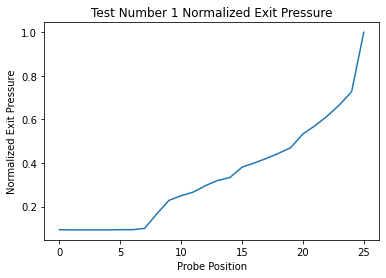

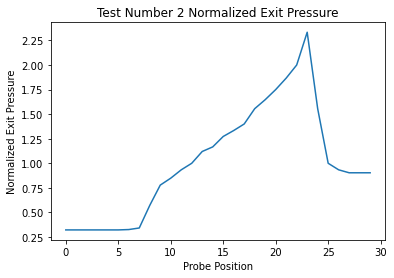

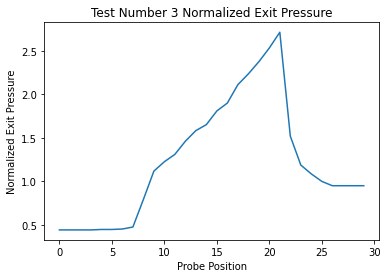

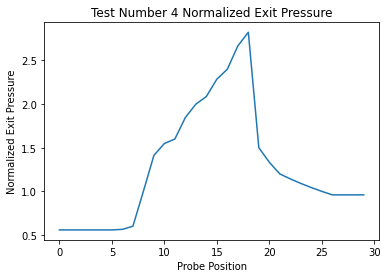

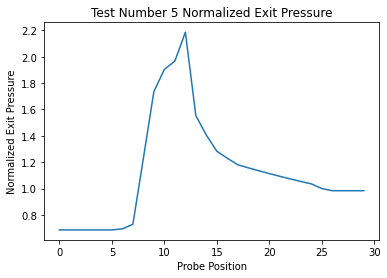

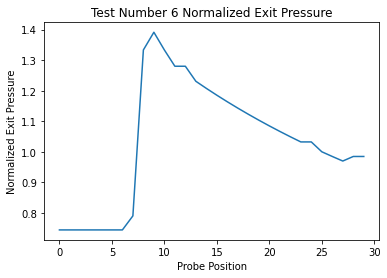

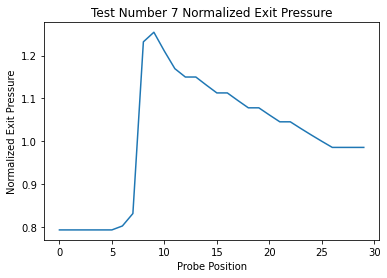

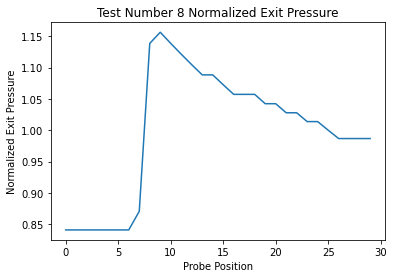

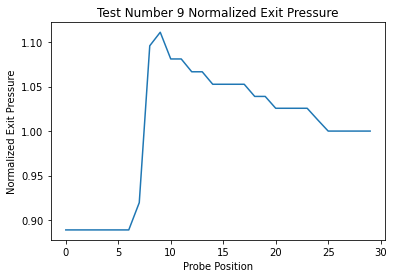

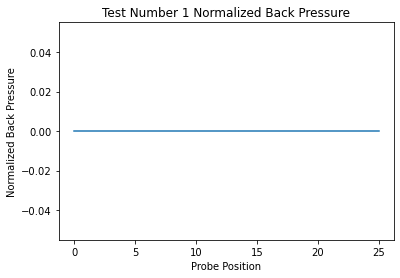

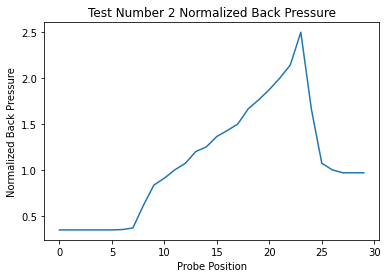

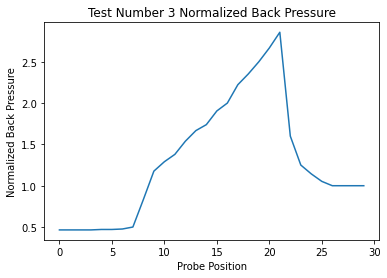

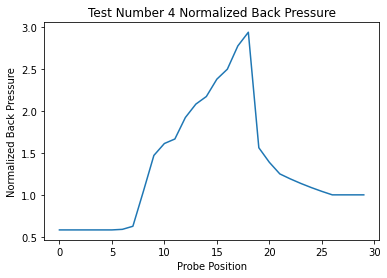

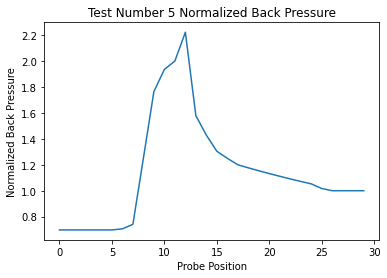

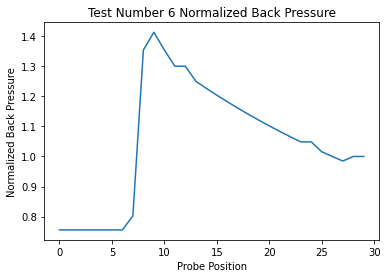

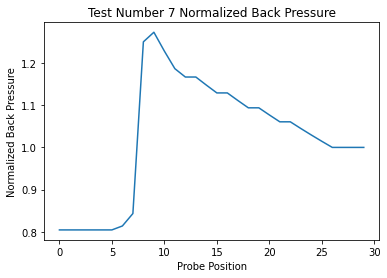

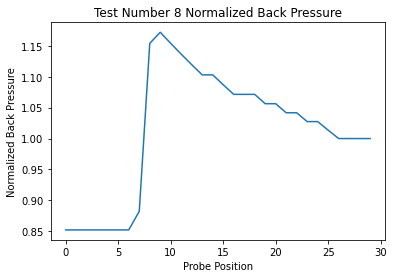

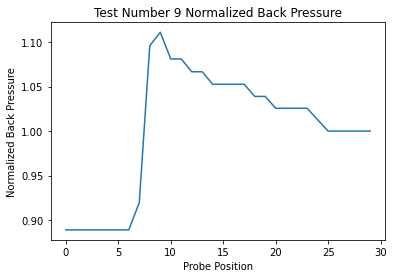

In [73]:
#constants
back_pressures = [0, 30, 40, 50, 60, 65, 70, 75, 80]
x = np.arange(0, 30, 1)

#finding the exit pressures for each test (at position 26)
exit_pressures = []
for i in range(9):
    exit_pressures.append(raw_data.iloc[25,i])

#creating the arrays for the data
p_e_norm_data = np.zeros((len(raw_data), 9))
p_b_norm_data = np.zeros((len(raw_data), 9))

#normalized exit pressures (pe/p0)
for i in range(9):
    for j in range(len(raw_data)):
        p_e_norm = exit_pressures[i]/raw_data.iloc[j,i]
        p_e_norm_data[j, i] = p_e_norm

#normalized back pressures (pb/p0)
for i in range(9):
    for j in range(len(raw_data)):
        p_b_norm = back_pressures[i]/raw_data.iloc[j,i]
        p_b_norm_data[j, i] = p_b_norm

#plotting the data
#exit pressure
for i in range(9):
    y = p_e_norm_data[:,i]
    plt.plot(x,y)
    plt.title("Test Number {} Normalized Exit Pressure".format(i+1))
    plt.ylabel("Normalized Exit Pressure")
    plt.xlabel("Probe Position")
    plt.show()

#back pressure
for i in range(9):
    y = p_b_norm_data[:,i]
    plt.plot(x,y)
    plt.title("Test Number {} Normalized Back Pressure".format(i+1))
    plt.ylabel("Normalized Back Pressure")
    plt.xlabel("Probe Position")
    plt.show()